In [1]:
import numpy as np
import cv2
import pyrealsense2 as rs
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import copy
import warnings
import json
import random

warnings.filterwarnings('ignore')

%config InlineBackend.figure_format = 'retina'

In [2]:
def cv2pil(image):
    ''' OpenCV型 -> PIL型 '''
    new_image = image.copy()
    if new_image.ndim == 2:  # モノクロ
        pass
    elif new_image.shape[2] == 3:  # カラー
        new_image = new_image[:, :, ::-1]
    elif new_image.shape[2] == 4:  # 透過
        new_image = new_image[:, :, [2, 1, 0, 3]]
    new_image = Image.fromarray(new_image)
    return new_image

In [3]:
class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)

In [4]:
def detect_contour(path):    
    src = cv2.imread(path, cv2.IMREAD_COLOR)

 # グレースケール画像へ変換
    gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)

 # 2値化
    retval, bw = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

  # 輪郭を抽出
  #   contours : [領域][Point No][0][x=0, y=1]
  #   cv2.CHAIN_APPROX_NONE: 中間点も保持する
  #   cv2.CHAIN_APPROX_SIMPLE: 中間点は保持しない
    contours, hierarchy = cv2.findContours(bw, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    print('len contours:', str(len(contours)))

  # 矩形検出された数（デフォルトで0を指定）
    detect_count = 0

  # 各輪郭に対する処理
    for i in range(0, len(contours)):

    # 輪郭の領域を計算
      area = cv2.contourArea(contours[i])

    # ノイズ（小さすぎる領域）と全体の輪郭（大きすぎる領域）を除外
      if area < 1e3: # or 1e5 < area
        continue

    # 外接矩形
      if len(contours[i]) > 0:
        rect = contours[i]
        x, y, w, h = cv2.boundingRect(rect)
        cv2.rectangle(src, (x, y), (x + w, y + h), (0, 255, 0), 2)

      # 外接矩形毎に画像を保存
        name = path[:-4]
        #cv2.imwrite(name+'_'+str(detect_count) + '.jpg', src[y:y + h, x:x + w])

        detect_count = detect_count + 1
        return y, y+h, x, x+w
def excute_obj(name):
    save_path = name+'.png'
    cv2.imwrite(save_path, image)
    y1, y2, x1, x2 = detect_contour(save_path)
    return y1, y2, x1, x2

In [5]:
def make_feature(img):
    area = img.shape[0]*img.shape[1]
    width = img.shape[1]
    height = img.shape[0]
    length = width+height
    depth_sum = 0
    for col in img:
        for d in col:
            depth_sum += d
    rate = round(depth_sum/area, 1)
    feature_dict = {'width': width, 'height': height, 'area': area, 'depth_sum': depth_sum, 'depth_sum/area': rate, 'length': length}
    return feature_dict

def make_result(name, range_list):
    global depth_cut
    data_list = []
    obj_result = make_feature(depth_cut)
    obj_dict = make_feature(depth_cut)
    for col in depth_cut:
        for data in col:
            data_list.append(data)
    obj_dict['depth_median'] = np.median(data_list)
    obj_dict['depth_mean'] = np.mean(data_list)
    obj_dict['depth'] = range_list
    result_dict[name] = obj_dict
    return result_dict

def make_result_v2(name):
    global depth_cut
    data_list = []
    obj_result = make_feature(depth_cut)
    obj_dict = make_feature(depth_cut)
    for col in depth_cut:
        for data in col:
            data_list.append(data)
    obj_dict['depth_median'] = np.median(data_list)
    obj_dict['depth_mean'] = round(np.mean(data_list), 1)
    result_dict[name] = obj_dict
    return result_dict

def make_feature_v3(depth_cut, name):
    data_list = []
    img = depth_cut
    area = img.shape[0]*img.shape[1]
    width = img.shape[1]
    height = img.shape[0]
    depth_sum = 0
    for col in img:
        for d in col:
            depth_sum += d
            data_list.append(d)
    depth_sum_area = depth_sum/area
    length = width+height
    depth_median = np.median(data_list)
    depth_mean = round(np.mean(data_list), 1)
    w_h = [width, height]
    ratio = max(w_h)/min(w_h)
    dataseries = {'width': width, 'height': height, 'area': area, 'depth_sum': depth_sum, 'depth_sum/area': depth_sum_area,
              'length': length, 'depth_median': depth_median, 'depth_mean': depth_mean, 'ratio': ratio, 'y': name}
    result_dict[name] = dataseries
    return result_dict

In [6]:
result_dict = {}

In [7]:
config = rs.config()

config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)
config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)


In [34]:
pipeline = rs.pipeline()
profile = pipeline.start(config)
align = rs.align(rs.stream.color)
count = 1
random_num = str(random.randint(0, 1000))
try:
    while True:

        frames = pipeline.wait_for_frames()
        aligned_frames = align.process(frames)
        
        color_frame = aligned_frames.get_color_frame()
        depth_frame = aligned_frames.get_depth_frame()
        if not depth_frame or not color_frame:
            continue
        
        # 指定距離以上を無視した深度画像
        depth_image = np.asanyarray(depth_frame.get_data())
        color_image = np.asanyarray(color_frame.get_data())
        cv2.imwrite('pan_data/'+random_num+'_color'+'.jpg', color_image)
        cv2.imwrite('pan_data/'+random_num+'_depth'+'.jpg', depth_image)

        count += 1
        if count == 20:
            break
                        

finally:
    # ストリーミング停止
    pipeline.stop()

In [35]:
check = cv2pil(color_image)
check.show()

In [36]:
unique_dict = {}
image_list = []
depth_copy = copy.deepcopy(depth_image)
for col in depth_image:
    for one in col:
        if one > 1000:
            image_list.append(0)
        else:
            image_list.append(one)
        if one not in unique_dict:
            unique_dict[one] = 1
        else:
            unique_dict[one] +=1

In [37]:
img_list_zoom = []
for pixel in image_list:
    if pixel > 150 and pixel < 390:
        img_list_zoom.append(pixel)

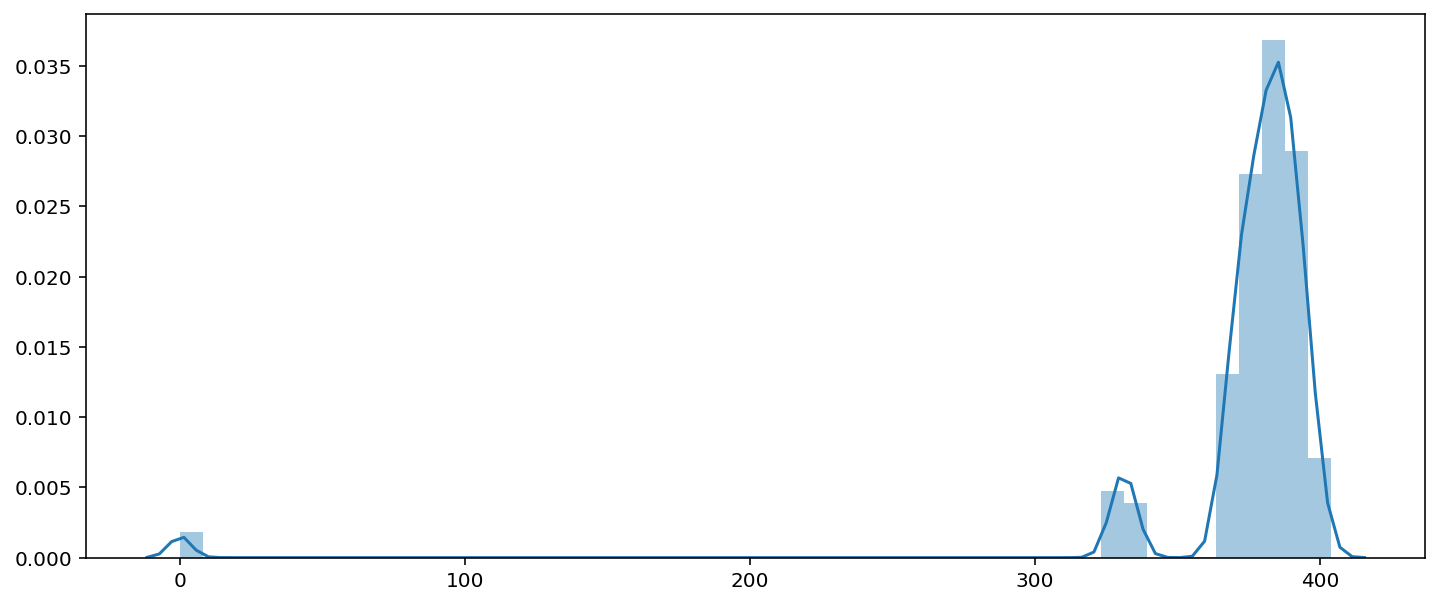

In [38]:
plt.figure(figsize=(12, 5))
sns.distplot(image_list)

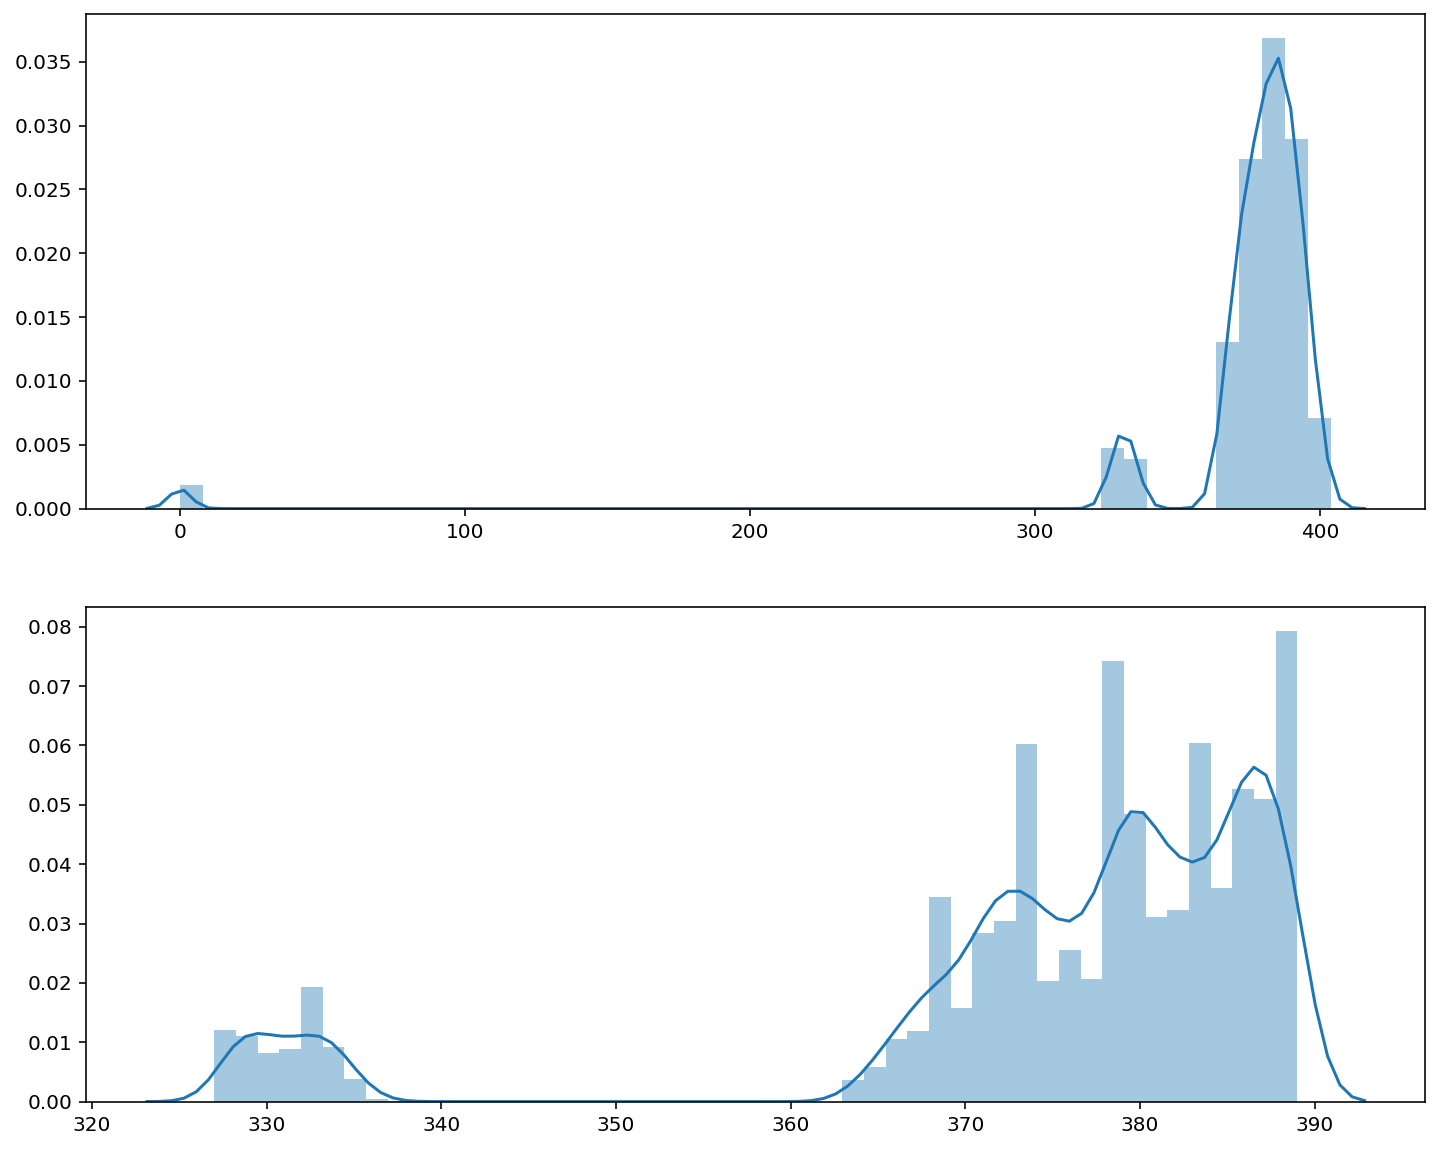

In [39]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10))
sns.distplot(image_list, ax=ax[0])
sns.distplot(img_list_zoom, ax=ax[1])

In [40]:
for y, col in enumerate(depth_image):
    for x, pixel in enumerate(col):
        if pixel > 50 and pixel < 360:  #black_box
        #if pixel < 334 and pixel > 320: #dog
            depth_image[y][x] = 0
        else:
            depth_image[y][x] = 255
image = np.array(depth_image, dtype=np.uint8)

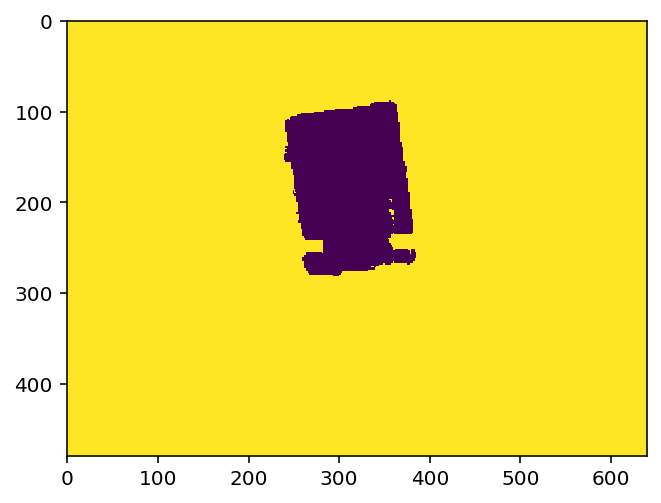

In [41]:
plt.imshow(image)

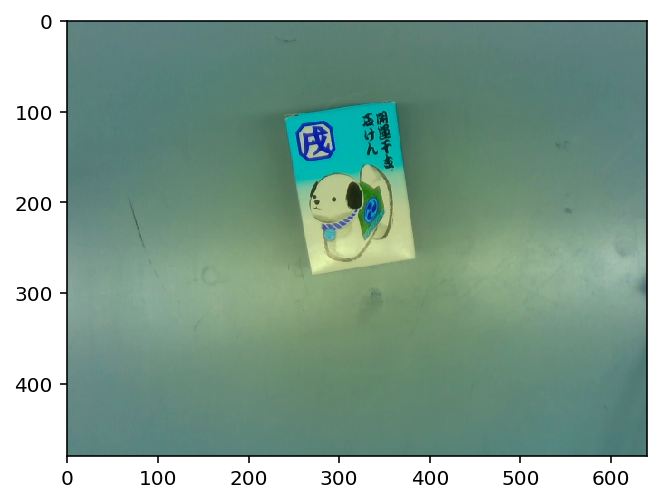

In [42]:
plt.imshow(color_image)

In [43]:
# image = cv2pil(image)
# p_image = cv2pil(color_image)

# mask = image.convert('L').resize(p_image.size)
# im = Image.composite(image, p_image, mask)

# im.show()
# im.save('362.png')

In [44]:
y1, y2, x1, x2 = excute_obj('mintia_x')

len contours: 4


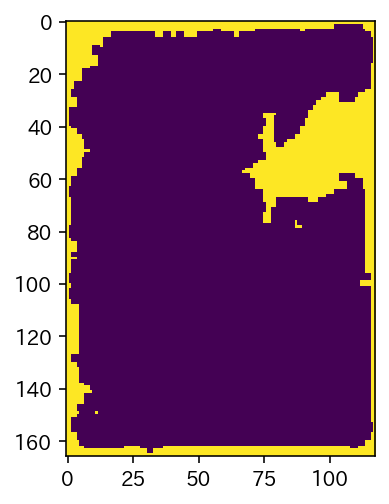

In [45]:
image = image[y1:y2, x1:x2]
plt.imshow(image)

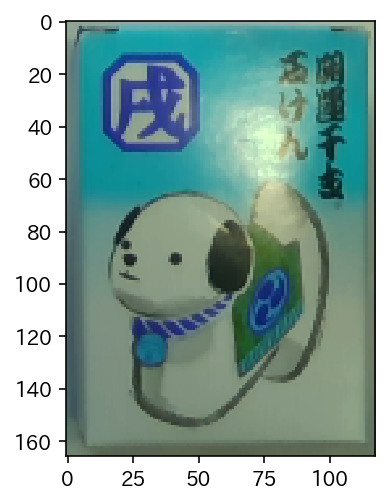

In [46]:
cut_color = color_image[y1:y2, x1:x2]
depth = depth_copy[y1:y2, x1:x2]
center_x = x1 + int((x2-x1)/2)
center_y = y1 + int((y2-y1)/2)
# sep1 = x1 + int((x2-x1)/3)
# sep2 = sep1 + int((x2-x1)/3)
# first = depth_copy[y1:y2, x1:sep1]
# second = depth_copy[y1:y2, sep1:sep2]
# third = depth_copy[y1:y2, sep2:x2]
first = depth_copy[y1:center_y, x1:center_x]
second = depth_copy[center_y:y2, x1:center_x]
third = depth_copy[y1:center_y, center_x:x2]
four = depth_copy[center_y:y2, center_x:x2]

plt.imshow(cut_color)

In [452]:
cut_list = []
for i in depth:
    for j in i:
            cut_list.append(j)

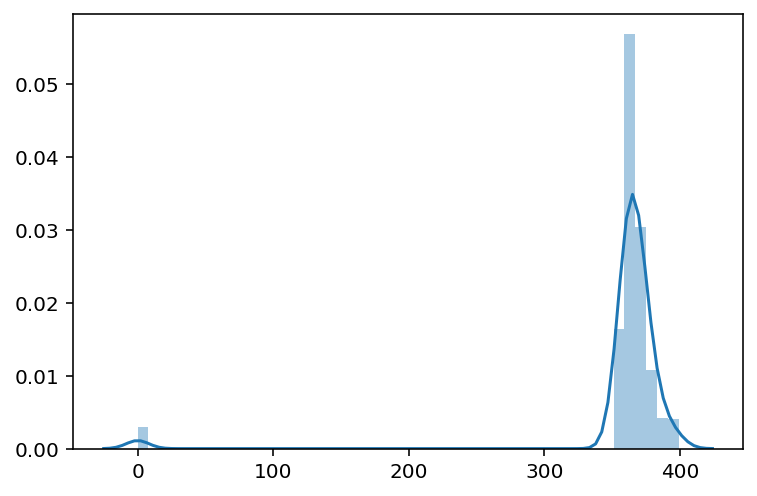

In [453]:
sns.distplot(cut_list)

In [454]:
print('X象限のデプス値の平均')
print('第一象限: ', round(np.mean(third), 0))
print('第二象限: ', round(np.mean(first), 0))
print('第三象限: ', round(np.mean(second), 0))
print('第四象限: ', round(np.mean(four), 0))
print('-'*25)
print('統計量')
print('mean:   ',round(np.mean(cut_list), 0))
print('median: ', np.median(cut_list))
print('max:    ', np.max(cut_list))
print('min:    ', np.min(cut_list))
print('size:   ', len(cut_list))
print('-'*25)
print('デプス値の四分位数')
sorted_cut_list = sorted(cut_list)
q2 = int(len(cut_list)/2)
q1 = int(q2/2)
q3 = q2 + q1
print('q1: ', sorted_cut_list[q1])
print('q2: ', sorted_cut_list[q2])
print('q3: ', sorted_cut_list[q3])

X象限のデプス値の平均
第一象限:  367.0
第二象限:  368.0
第三象限:  335.0
第四象限:  366.0
-------------------------
統計量
mean:    359.0
median:  366.0
max:     399
min:     0
size:    13578
-------------------------
デプス値の四分位数
q1:  361
q2:  366
q3:  371


<h1>OCR</h1>

In [571]:
gray = cv2.cvtColor(color_image, cv2.COLOR_RGB2GRAY)
#th3 = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
#ret3,th3 = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
width, height = gray.shape[1], gray.shape[0]
gray = cv2.resize(gray , (int(width*3), int(height*3)))
threshold = 100
ret, img_thresh = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)
img = cv2pil(img_thresh)
builder = pyocr.builders.TextBuilder(tesseract_layout=6)
result = tool.image_to_string(img, lang='jpn+eng', builder=builder)

print(result)

EY] 7
Sica アレ ル ;
EXD A
TVs
V4 い ー# に いい 』* い いく 導 財 人
a A


In [570]:
img.show()

In [541]:
resize_color = cv2.resize(color_image, (int(width*2), int(height*2)))
cv2.imwrite('test.jpg', resize_color)
gray = cv2.cvtColor(resize_color, cv2.COLOR_RGB2GRAY)
#ret3, th3 = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
threshold = 80
ret, img_thresh = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)
img = cv2pil(img_thresh)
builder = pyocr.builders.WordBoxBuilder(tesseract_layout=6)
result = tool.image_to_string(img, lang='jpn', builder=builder)

img = cv2.imread('test.jpg')
for d in result:
    cv2.rectangle(img, d.position[0], d.position[1], (0, 0, 255), 2)
pil_img = cv2pil(img)
pil_img.show()